In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import matplotlib.colors as colors

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")

import seawater as sw

In [2]:
# client = Client(n_workers=90)
# # client = Client(cluster)

client = Client(n_workers=15,processes=True)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 135,Total memory: 502.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40253,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 135
Started: Just now,Total memory: 502.98 GiB
Comm: tcp://127.0.0.1:42625,Total threads: 9
Dashboard: http://127.0.0.1:38147/status,Memory: 33.53 GiB
Nanny: tcp://127.0.0.1:44187,


## Reading CROCO (3D)

In [3]:
# chunks={'time_counter':1}

full_path=glob('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M*.nc')[::2][:-1]
smth_path=glob('/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M*.nc')[::2][:-1]


varf=xr.open_mfdataset(full_path,data_vars='minimal')
vart=xr.open_mfdataset(smth_path,data_vars='minimal')



# varf=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M06.nc',data_vars='minimal')
# vart=xr.open_mfdataset('/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M06.nc',data_vars='minimal')



In [4]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
timer_h=pd.DatetimeIndex(vart.time_counter)
timer_d=pd.DatetimeIndex(vart.time_counter.groupby("time_counter.dayofyear").mean())

# Loading data

In [6]:
rho_air=1.25
c_d=1e-3

In [7]:
%%time
u_full_time=varf.UOCE[:,30:-30,30:-90].compute()
v_full_time=varf.VOCE[:,30:-30,30:-90].compute()

CPU times: user 1.82 s, sys: 1.72 s, total: 3.54 s
Wall time: 37.9 s


In [8]:
%%time
u_smth_time=vart.UOCE[:,30:-30,30:-90].compute()
v_smth_time=vart.VOCE[:,30:-30,30:-90].compute()

CPU times: user 1.74 s, sys: 1.72 s, total: 3.47 s
Wall time: 38.9 s


In [9]:
%%time
uwind_full_time=varf.U10[:,30:-30,30:-90].compute()
vwind_full_time=varf.V10[:,30:-30,30:-90].compute()

uwind_smth_time=vart.U10[:,30:-30,30:-90].compute()
vwind_smth_time=vart.V10[:,30:-30,30:-90].compute()

CPU times: user 3.82 s, sys: 3.57 s, total: 7.4 s
Wall time: 1min 22s


In [10]:
U_ref_speed_full=np.sqrt((uwind_full_time-u_full_time)**2+(vwind_full_time-v_full_time)**2)
U_ref_speed_smth=np.sqrt((uwind_smth_time-u_smth_time)**2+(vwind_smth_time-v_smth_time)**2)


taux_full=(rho_air*c_d)*(U_ref_speed_full)*(uwind_full_time-u_full_time)
tauy_full=(rho_air*c_d)*(U_ref_speed_full)*(uwind_full_time-u_full_time)


taux_smth=(rho_air*c_d)*(U_ref_speed_smth)*(uwind_smth_time-u_smth_time)
tauy_smth=(rho_air*c_d)*(U_ref_speed_smth)*(uwind_smth_time-u_smth_time)

In [207]:
nf=4
dxx=2000
sclstr='density'
wdws='hann' #'flattop','hann'
wdw_cor=True
phase_bol=True
truncate_bol=True

### Windwork

In [208]:
tau_u_full_spec=xrft.cross_spectrum(taux_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    u_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_v_full_spec=xrft.cross_spectrum(tauy_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    v_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_u_smth_spec=xrft.cross_spectrum(taux_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    u_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_v_smth_spec=xrft.cross_spectrum(tauy_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    v_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)



# ww_full_spec=(1/1024)*(tau_u_full_spec + tau_v_full_spec)
# ww_smth_spec=(1/1024)*(tau_u_smth_spec + tau_v_smth_spec)

ww_full_spec=(tau_u_full_spec + tau_v_full_spec)
ww_smth_spec=(tau_u_smth_spec + tau_v_smth_spec)

ww_iso_full=xrft.isotropize(ww_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
ww_iso_smth=xrft.isotropize(ww_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)


### EKE FULL

In [209]:
u_full_spec=xrft.power_spectrum(u_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

v_full_spec=xrft.power_spectrum(v_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


u_smth_spec=xrft.power_spectrum(u_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)
v_smth_spec=xrft.power_spectrum(v_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

u_iso_full=xrft.isotropize(u_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
v_iso_full=xrft.isotropize(v_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

u_iso_smth=xrft.isotropize(u_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
v_iso_smth=xrft.isotropize(v_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

EKE_spec_full=0.5*(u_iso_full+v_iso_full)
EKE_spec_smth=0.5*(u_iso_smth+v_iso_smth)



### Wind

In [14]:
uwind_full_spec=xrft.power_spectrum(uwind_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

vwind_full_spec=xrft.power_spectrum(vwind_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


uwind_smth_spec=xrft.power_spectrum(uwind_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)
vwind_smth_spec=xrft.power_spectrum(vwind_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

uwind_iso_full=xrft.isotropize(uwind_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
vwind_iso_full=xrft.isotropize(vwind_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

uwind_iso_smth=xrft.isotropize(uwind_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
vwind_iso_smth=xrft.isotropize(vwind_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

windEKE_spec_full=0.5*(uwind_iso_full+vwind_iso_full)
windEKE_spec_smth=0.5*(uwind_iso_smth+vwind_iso_smth)



# Plots

In [15]:
print('Mean inertial period = {0:0.1f} hours'.format((1/(sw.f(varf.nav_lat.mean())/(2*np.pi)))/60/60)) #because it is divided by 2pi (cicles)

Mean inertial period = 20.0 hours


### SMTH and FULL windwork

Text(0.5, 0, 'Wavenumber [cpm]')

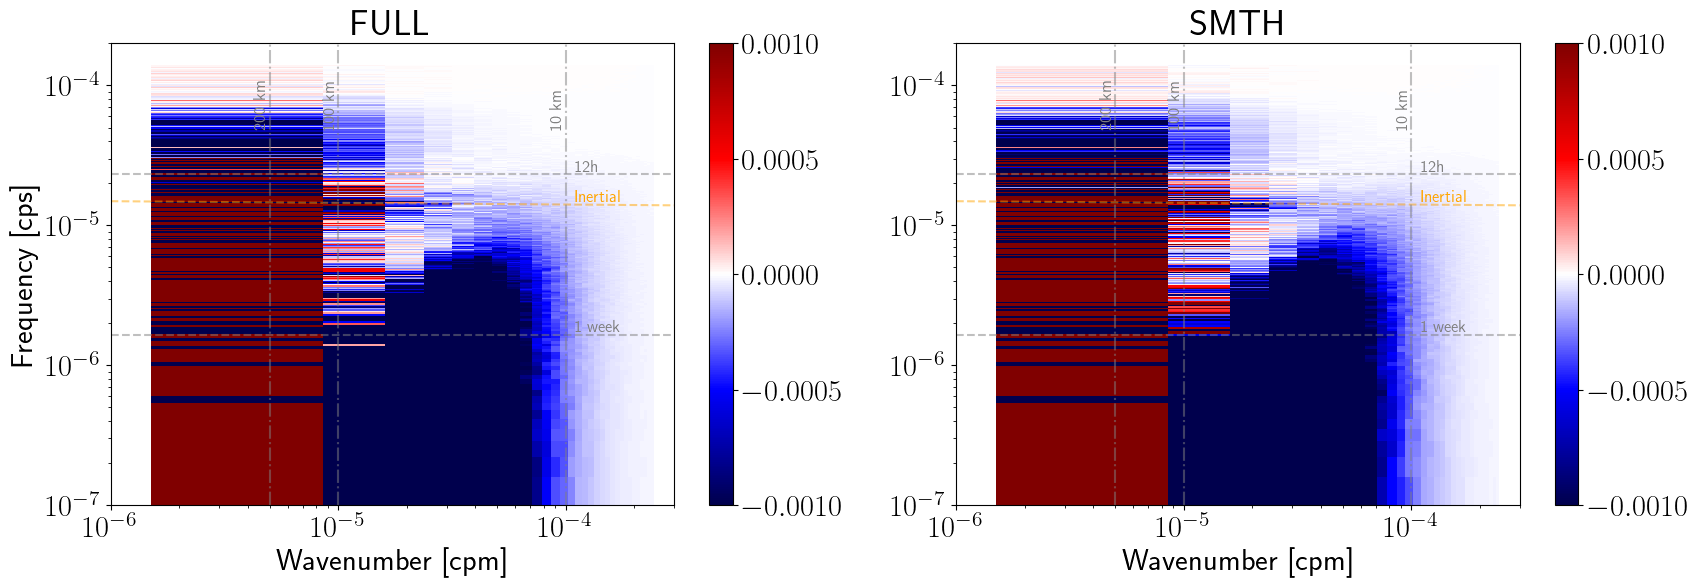

In [210]:
val_min=-1e-3
val_max=1e-3
xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

# xmin=0;xmax=3e-4;ymax=1e-4;ymin=-1e-4
dxx=2000
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.pcolormesh(ww_iso_full.freq_r/dxx,ww_iso_full.freq_time_counter,
                ww_iso_full.real/dxx,cmap='seismic',vmin=val_min,vmax=val_max)

# plt.pcolormesh(ww_iso_full.freq_r/dxx,ww_iso_full.freq_ocean_time/dtt,
#                 ww_iso_full.real,cmap='seismic',
#                norm=colors.SymLogNorm(linthresh=1e-5,vmin=val_min,vmax=val_max, base=10))


'Lines for f'
plt.plot([xmin,xmax],[sw.f(varf.nav_lat.mean()/(2*np.pi)),sw.f(varf.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(varf.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')




plt.subplot(1,2,2)
# plt.pcolormesh(ww_iso_smth.freq_r/dxx,ww_iso_smth.freq_ocean_time/dtt,
#                 ww_iso_smth.real,cmap='seismic',
#                norm=colors.SymLogNorm(linthresh=1e-3,vmin=val_min,vmax=val_max, base=10))

plt.pcolormesh(ww_iso_smth.freq_r/dxx,ww_iso_full.freq_time_counter,
                ww_iso_smth.real/dxx,cmap='seismic',vmin=val_min,vmax=val_max)

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')



In [219]:
# band_ww_full=(ww_iso_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5))
# band_ww_smth=(ww_iso_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5))

band_ww_full=(ww_iso_full)
band_ww_smth=(ww_iso_smth)

Text(0.5, 0, 'Wavenumber [cpm]')

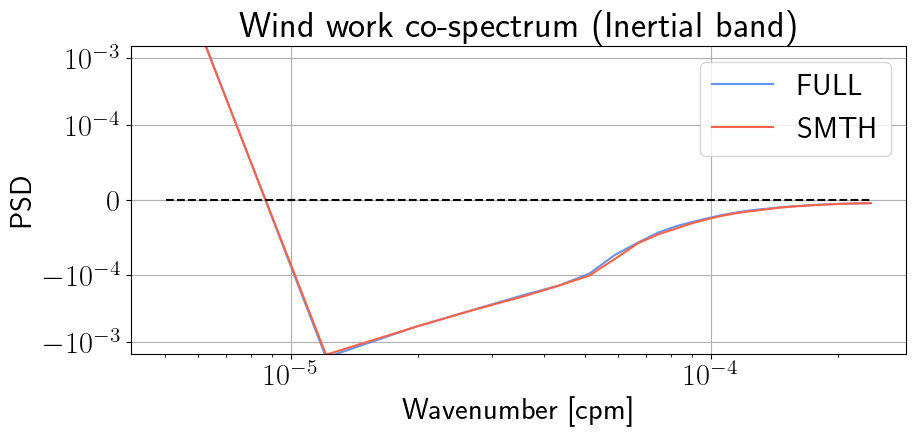

In [221]:
plt.figure(figsize=(10,4))
plt.plot(band_ww_full.freq_r/dxx,band_ww_full.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_ww_smth.freq_r/dxx,band_ww_smth.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')
plt.plot([(band_ww_full.freq_r/dxx).min(),(band_ww_full.freq_r/dxx).max()],[0,0],'k--')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('symlog', linthresh=1e-4)
plt.grid()
# plt.xlim(1e-5,xmax)
plt.ylim(-0.15e-2,0.15e-2)

plt.title('Wind work co-spectrum (Inertial band)')
# plt.title('Wind work co-spectrum (16-20h band)')

plt.ylabel(r'PSD ')
plt.xlabel(r'Wavenumber [cpm]')



### EKE plots

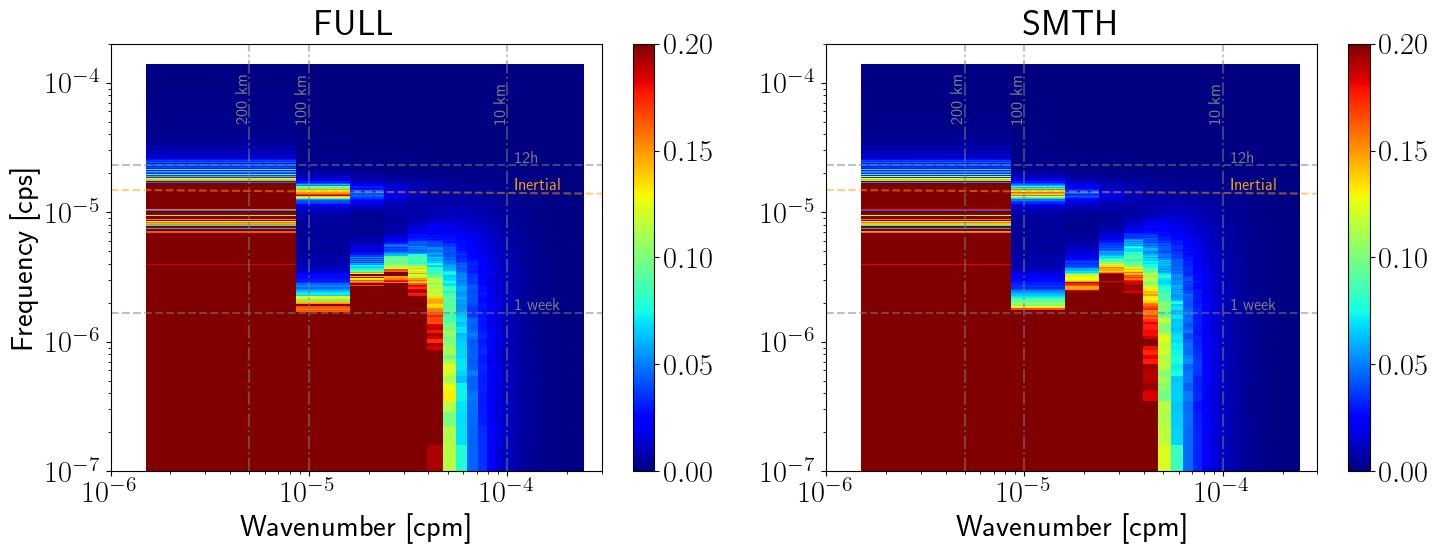

In [106]:
val_min=0
val_max=0.2
xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(EKE_spec_full.freq_r/dxx,EKE_spec_full.freq_time_counter,
               ((EKE_spec_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)




plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(EKE_spec_smth.freq_r/dxx,EKE_spec_smth.freq_time_counter,
               ((EKE_spec_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

In [222]:
# band_EKE_full=(EKE_spec_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5))
# band_EKE_smth=(EKE_spec_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5))
band_EKE_full=(EKE_spec_full)
band_EKE_smth=(EKE_spec_smth)


Text(0.5, 0, 'Wavenumber [cpm]')

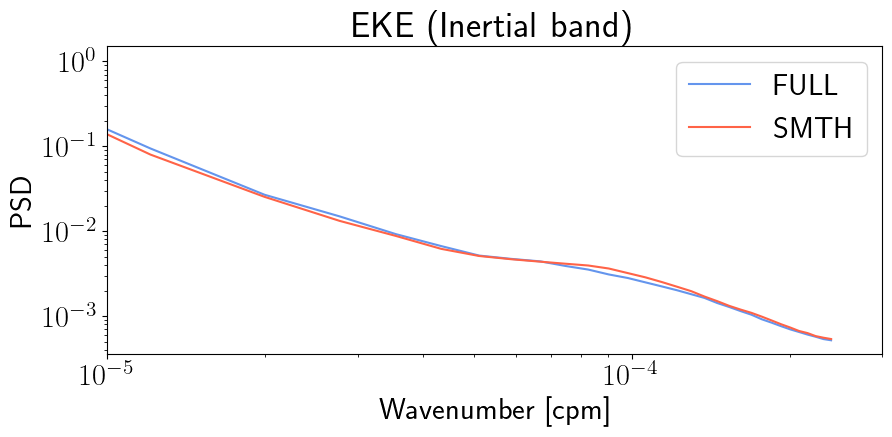

In [186]:
plt.figure(figsize=(10,4))
plt.plot(band_EKE_full.freq_r/dxx,band_EKE_full.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_EKE_smth.freq_r/dxx,band_EKE_smth.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5,xmax)
# plt.ylim(5e-4,2e-1)
plt.title('EKE (Inertial band)')
plt.ylabel(r'PSD ')
plt.xlabel(r'Wavenumber [cpm]')






Text(0.5, 0, 'Wavenumber [km$^{-1}$]')

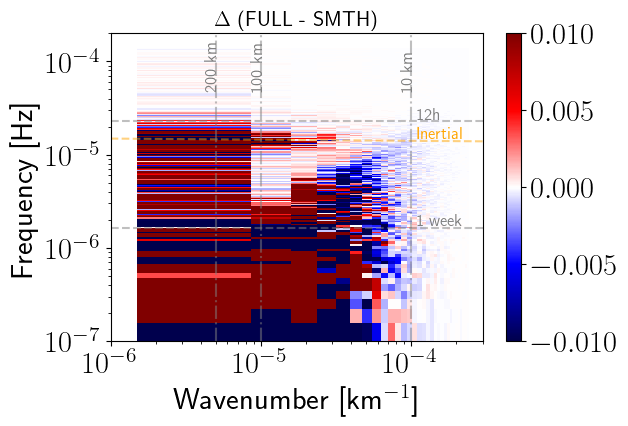

In [260]:
val_min=-1e-2
val_max=1e-2

plt.figure(figsize=(6,4))
plt.pcolormesh(EKE_spec_full.freq_r/dxx,EKE_spec_full.freq_time_counter,
               (EKE_spec_full.real-EKE_spec_smth.real)/dxx,vmin=val_min,vmax=val_max,cmap='seismic')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(varf.nav_lat.mean()/(2*np.pi)),sw.f(varf.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(varf.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)




plt.title(r'$\Delta$ (FULL - SMTH)',fontsize=15)



plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.ylabel(r'Frequency [Hz]')
plt.xlabel(r'Wavenumber [km$^{-1}$]')



### Wind EKE Spectrum

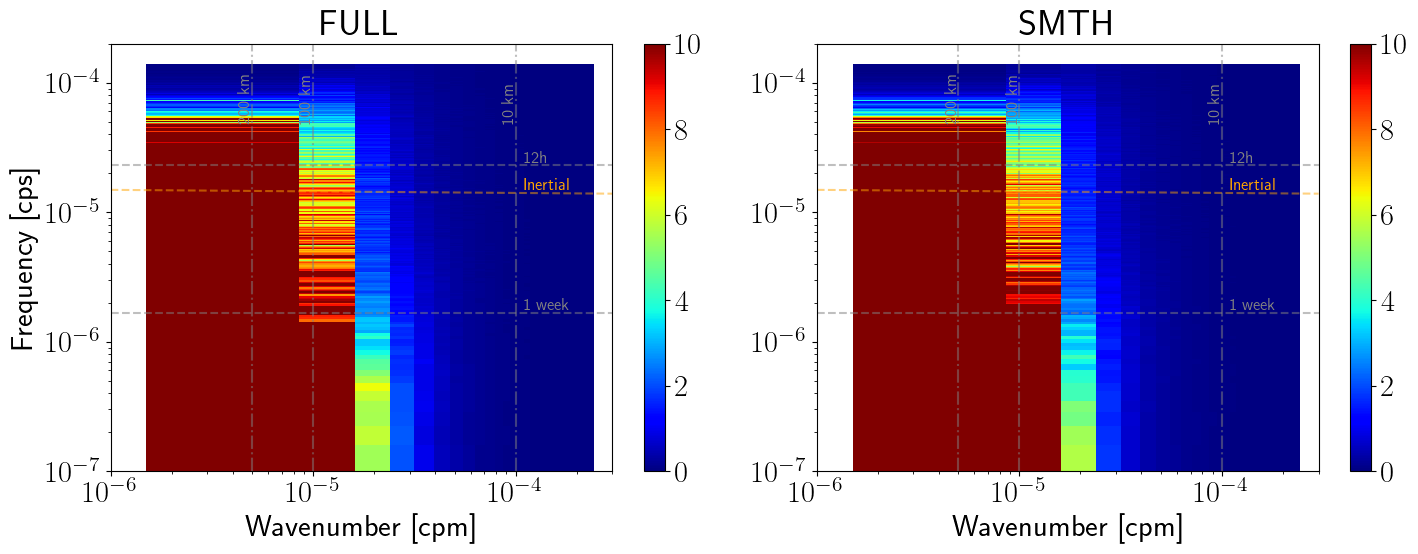

In [261]:
val_min=0
val_max=10

xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(windEKE_spec_full.freq_r/dxx,windEKE_spec_full.freq_time_counter,
               ((windEKE_spec_full.real/dxx)),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(varf.nav_lat.mean()/(2*np.pi)),sw.f(varf.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(varf.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)



plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(windEKE_spec_smth.freq_r/dxx,windEKE_spec_smth.freq_time_counter,
               ((windEKE_spec_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')


'Lines for f'
plt.plot([xmin,xmax],[sw.f(varf.nav_lat.mean()/(2*np.pi)),sw.f(varf.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(varf.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)




'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)

plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

## Vorticity Spectrum

In [299]:
zeta_full=v_full_time.differentiate('x')/dxx - u_full_time.differentiate('y')/dxx
zeta_smth=v_smth_time.differentiate('x')/dxx - u_smth_time.differentiate('y')/dxx


zeta_full_spec=xrft.power_spectrum(zeta_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


zeta_smth_spec=xrft.power_spectrum(zeta_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

zeta_iso_full=xrft.isotropize(zeta_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
zeta_iso_smth=xrft.isotropize(zeta_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)



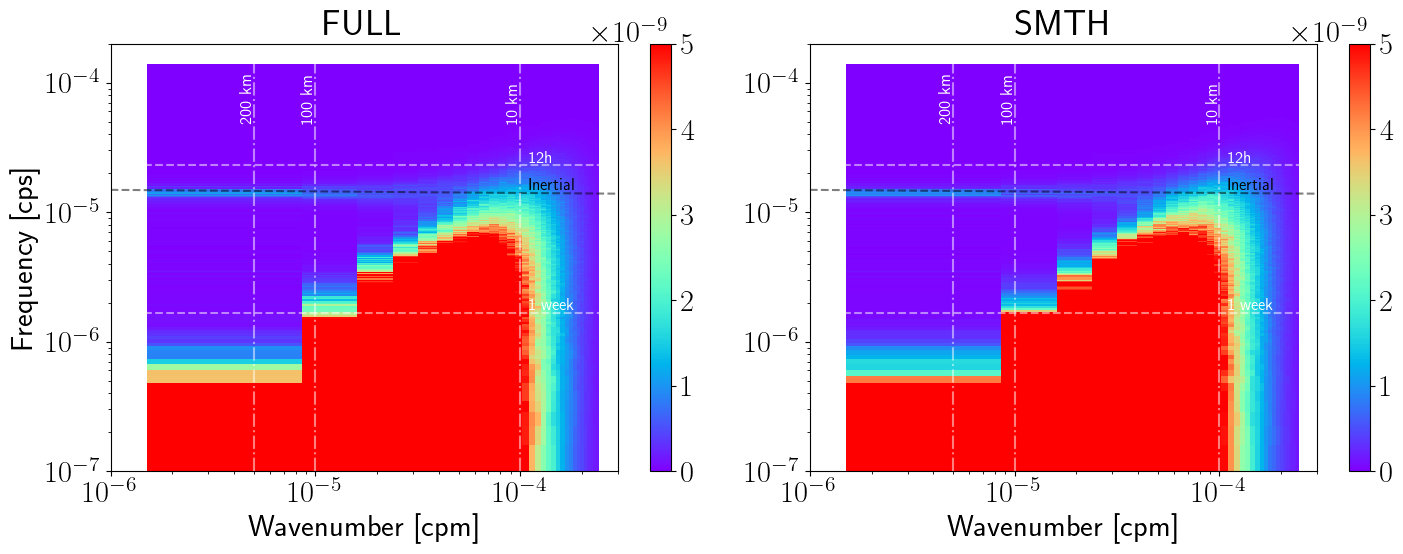

In [312]:
val_min=0
val_max=0.5e-8
xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(zeta_iso_full.freq_r/dxx,zeta_iso_full.freq_time_counter,
               ((zeta_iso_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')
'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='white',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='white',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='white',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='white',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='white',fontsize=12,rotation=90)



plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(zeta_iso_smth.freq_r/dxx,zeta_iso_smth.freq_time_counter,
               ((zeta_iso_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='white',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='white',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='white',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='white',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='white',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

In [307]:
band_zeta_full=(zeta_iso_full).sel(freq_time_counter=slice(1e-5,2e-5))
band_zeta_smth=(zeta_iso_smth).sel(freq_time_counter=slice(1e-5,2e-5))

Text(0.5, 0, 'Wavenumber [cpm]')

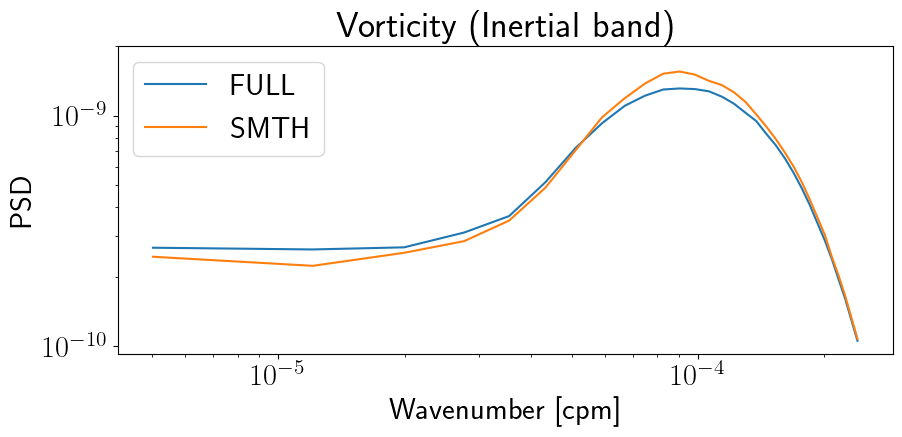

In [328]:
plt.figure(figsize=(10,4))
plt.plot(band_zeta_full.freq_r/dxx,band_zeta_full.mean('freq_time_counter')/dxx,label='FULL')
plt.plot(band_zeta_smth.freq_r/dxx,band_zeta_smth.mean('freq_time_counter')/dxx,label='SMTH')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-5,xmax)
plt.ylim(0,2e-9)

plt.title('Vorticity (Inertial band)')
plt.ylabel(r'PSD ')
plt.xlabel(r'Wavenumber [cpm]')


## Divergence Spectrum

In [85]:
sigma_full=u_full_time.differentiate('x')/dxx + v_full_time.differentiate('y')/dxx
sigma_smth=u_smth_time.differentiate('x')/dxx + v_smth_time.differentiate('y')/dxx

f_bar=sw.f(vart.nav_lat.mean())

In [116]:
sigma_full_spec=xrft.power_spectrum(sigma_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


sigma_smth_spec=xrft.power_spectrum(sigma_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

sigma_iso_full=xrft.isotropize(sigma_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
sigma_iso_smth=xrft.isotropize(sigma_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)




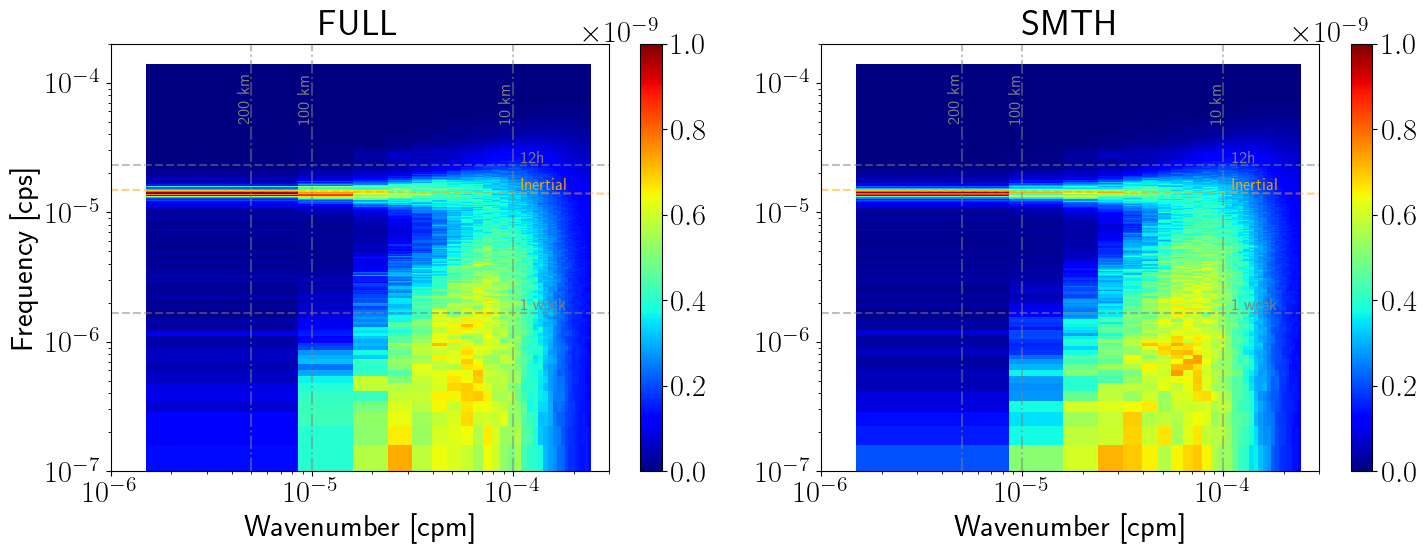

In [117]:
val_min=0
val_max=1e-9
xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
               ((sigma_iso_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)




plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(sigma_iso_smth.freq_r/dxx,sigma_iso_smth.freq_time_counter,
               ((sigma_iso_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

In [122]:
band_sigma_full=(sigma_iso_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5))
band_sigma_smth=(sigma_iso_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5))

Text(0.5, 0, 'Wavenumber [cpm]')

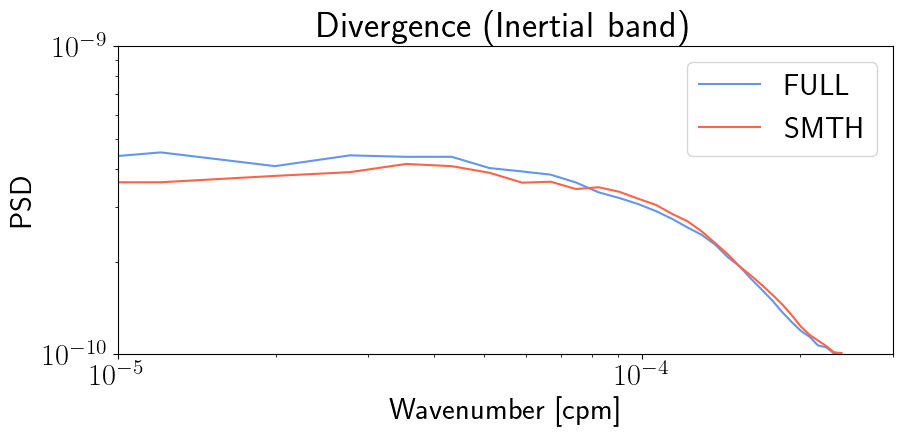

In [124]:
plt.figure(figsize=(10,4))
plt.plot(band_sigma_full.freq_r/dxx,band_sigma_full.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_sigma_smth.freq_r/dxx,band_sigma_smth.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5,xmax)
plt.ylim(1e-10,1e-9)

plt.title('Divergence (Inertial band)')
plt.ylabel(r'PSD ')
plt.xlabel(r'Wavenumber [cpm]')






# Monthly Analysis

In [55]:
monstr=['Jan','Feb','Mar','Apr','May','Jun']
mont_int=np.unique(u_full_time.time_counter.dt.month)

In [25]:
WW_FULL_table=[]
WW_SMTH_table=[]

for month_x in range(6):

    tx_full_m=taux_full[taux_full.time_counter.dt.month==month_x+1]
    ty_full_m=tauy_full[tauy_full.time_counter.dt.month==month_x+1]
    tx_smth_m=taux_smth[taux_smth.time_counter.dt.month==month_x+1]
    ty_smth_m=tauy_smth[tauy_smth.time_counter.dt.month==month_x+1]
    
    u_full_m=u_full_time[u_full_time.time_counter.dt.month==month_x+1]
    v_full_m=v_full_time[v_full_time.time_counter.dt.month==month_x+1]
    u_smth_m=u_smth_time[u_smth_time.time_counter.dt.month==month_x+1]
    v_smth_m=v_smth_time[v_smth_time.time_counter.dt.month==month_x+1]

    taux_full_m_spec=xrft.cross_spectrum(tx_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        u_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    tauy_full_m_spec=xrft.cross_spectrum(ty_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        v_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    taux_smth_m_spec=xrft.cross_spectrum(tx_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        u_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    tauy_smth_m_spec=xrft.cross_spectrum(ty_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        v_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    ww_full_spec_m=(taux_full_m_spec + tauy_full_m_spec)
    ww_smth_spec_m=(taux_smth_m_spec + tauy_smth_m_spec)

    ww_iso_full_m=xrft.isotropize(ww_full_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    ww_iso_smth_m=xrft.isotropize(ww_smth_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    WW_FULL_table.append(ww_iso_full_m)
    WW_SMTH_table.append(ww_iso_smth_m)

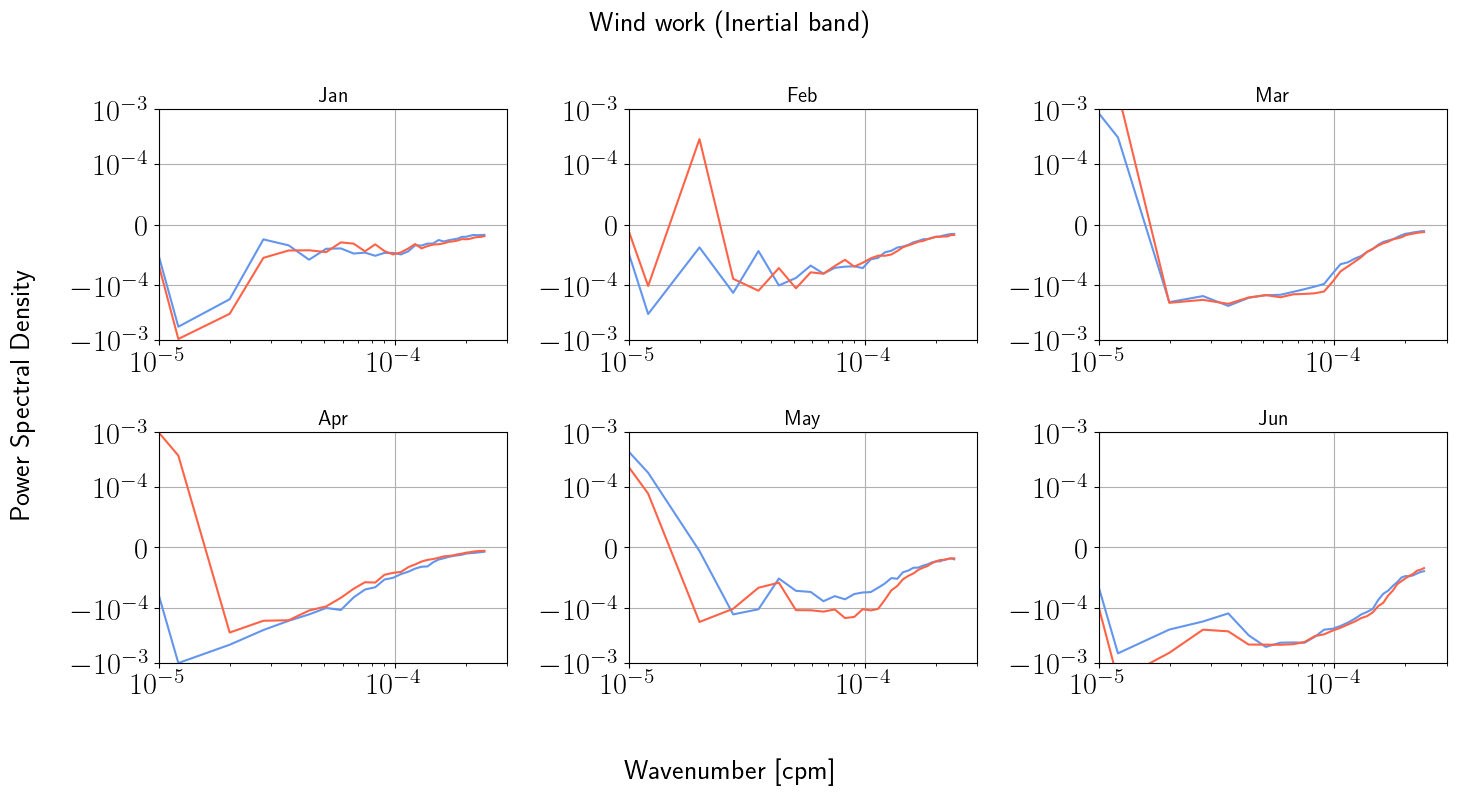

In [218]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    WW_FULL_band=(WW_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    WW_SMTH_band=(WW_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))

    ax[i].plot(WW_FULL_band.freq_r/dxx,WW_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(WW_SMTH_band.freq_r/dxx,WW_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('symlog',linthresh=1e-4)
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(-1e-3,1e-3)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()
    # ax[1].set_ylim(1e-10,0.6e-9)



fig.suptitle('Wind work (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

In [66]:
EKE_FULL_table=[]
EKE_SMTH_table=[]

for month_x in range(6):

    u_full_m=u_full_time[u_full_time.time_counter.dt.month==month_x+1]
    v_full_m=v_full_time[v_full_time.time_counter.dt.month==month_x+1]
    u_smth_m=u_smth_time[u_smth_time.time_counter.dt.month==month_x+1]
    v_smth_m=v_smth_time[v_smth_time.time_counter.dt.month==month_x+1]

    u_full_m_spec=xrft.power_spectrum(u_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    v_full_m_spec=xrft.power_spectrum(v_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    u_smth_m_spec=xrft.power_spectrum(u_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    v_smth_m_spec=xrft.power_spectrum(v_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    EKE_full_spec_m=(u_full_m_spec + v_full_m_spec)
    EKE_smth_spec_m=(u_smth_m_spec + v_smth_m_spec)

    EKE_iso_full_m=xrft.isotropize(EKE_full_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    EKE_iso_smth_m=xrft.isotropize(EKE_smth_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    EKE_FULL_table.append(EKE_iso_full_m)
    EKE_SMTH_table.append(EKE_iso_smth_m)

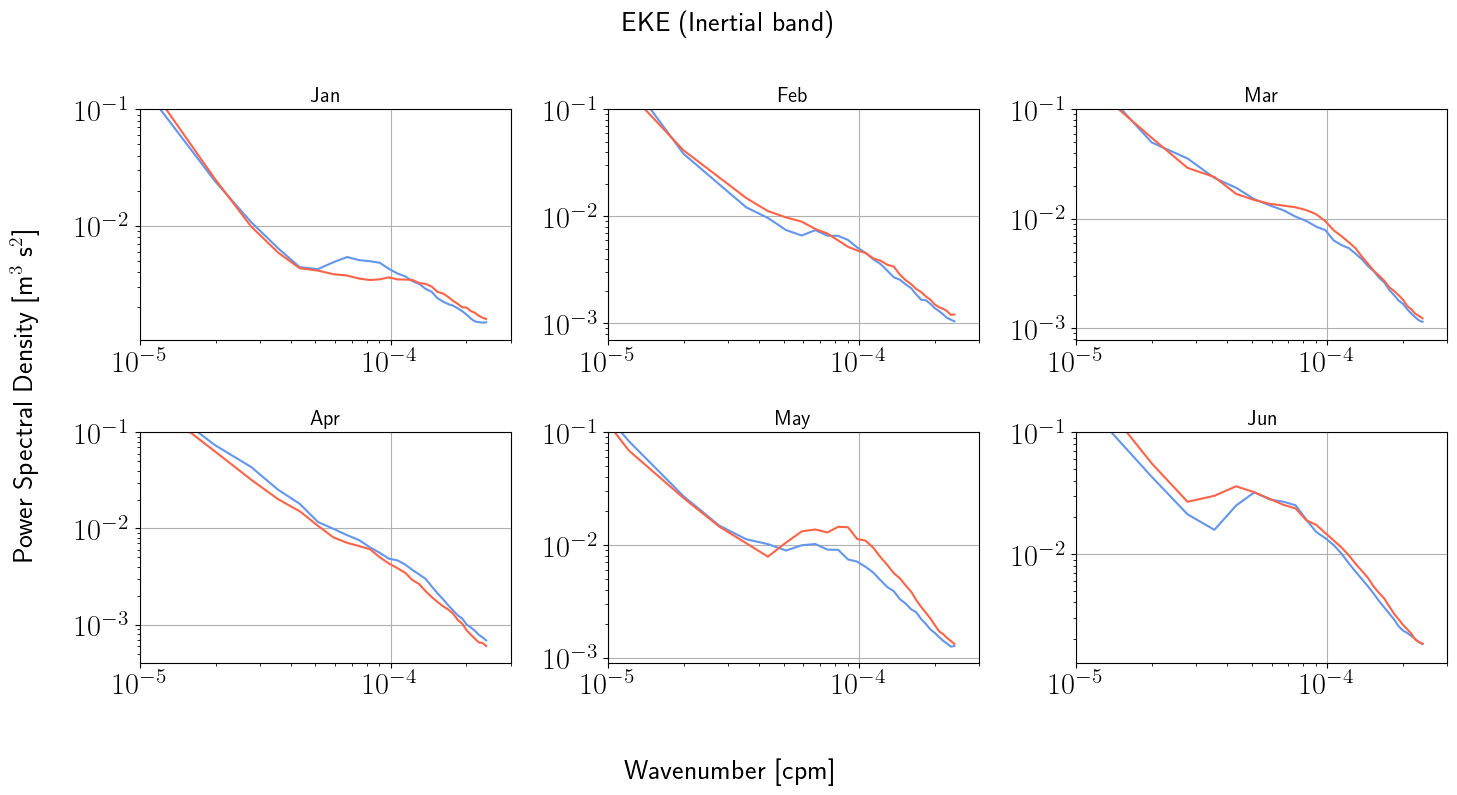

In [217]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    EKE_FULL_band=(EKE_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    EKE_SMTH_band=(EKE_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    

    ax[i].plot(EKE_FULL_band.freq_r/dxx,EKE_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(EKE_SMTH_band.freq_r/dxx,EKE_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(0,1e-1)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()
    # ax[1].set_ylim(1e-10,0.6e-9)



fig.suptitle('EKE (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density [m$^3$ s$^2$] ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

In [87]:
sigma_FULL_table=[]
sigma_SMTH_table=[]

for month_x in range(6):

    sigma_full_m=sigma_full[sigma_full.time_counter.dt.month==month_x+1]
    sigma_smth_m=sigma_smth[sigma_smth.time_counter.dt.month==month_x+1]

    sigma_full_m_spec=xrft.power_spectrum(sigma_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)


    sigma_smth_m_spec=xrft.power_spectrum(sigma_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    sigma_iso_full_m=xrft.isotropize(sigma_full_m_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    sigma_iso_smth_m=xrft.isotropize(sigma_smth_m_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    sigma_FULL_table.append(sigma_iso_full_m)
    sigma_SMTH_table.append(sigma_iso_smth_m)

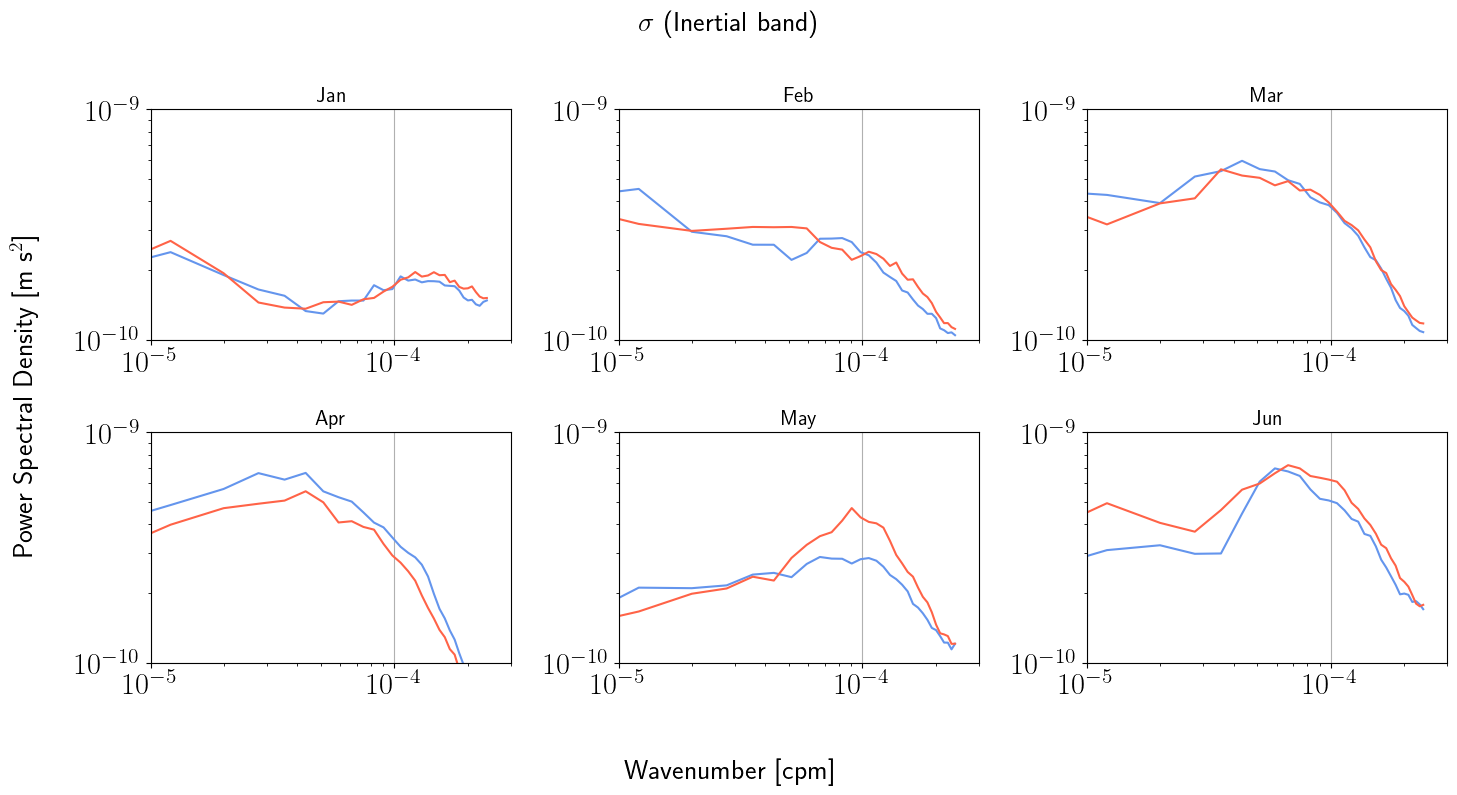

In [93]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    sigma_FULL_band=(sigma_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    sigma_SMTH_band=(sigma_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))

    ax[i].plot(sigma_FULL_band.freq_r/dxx,sigma_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(sigma_SMTH_band.freq_r/dxx,sigma_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(1e-10,1e-9)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()



fig.suptitle(r'$\sigma$ (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density [m s$^2$] ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

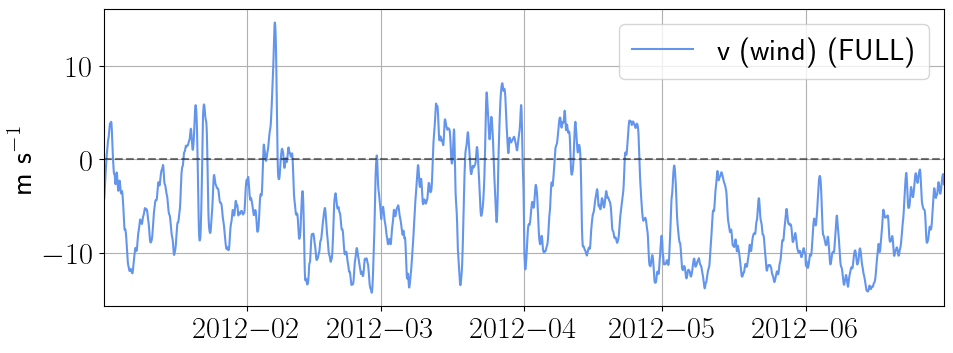

In [239]:
plt.figure(figsize=(10,4))
plt.plot(vwind_full_time.time_counter,(vwind_full_time).mean(['x','y']).rolling(time_counter=3).mean(),color='cornflowerblue',label='v (wind) (FULL)')
# plt.plot(vwind_smth_time.time_counter,(vwind_smth_time).mean(['x','y']).rolling(time_counter=3).mean(),color='navy',label='v (wind) (SMTH)')



plt.legend()
# plt.ylim(-13,13)
plt.hlines(xmin=uwind_full_time.time_counter.min().data,
           xmax=uwind_full_time.time_counter.max().data,y=0,color='k',linestyle='--',alpha=0.5)
plt.xlim(uwind_full_time.time_counter.min().data,uwind_full_time.time_counter.max().data)

plt.grid()
plt.ylabel(r'm s$^{-1}$')
plt.tight_layout()